In [210]:
%matplotlib notebook
import matplotlib.pylab as plt

import numpy as np
import pandas as pd

import numpy as np
import importlib
import integralclient as ic
importlib.reload(ic)
ic.__file__

In [295]:
t0_utc="2020-04-28T14:34:33"
t1_rel_days=-1
t2_rel_days=1.5
source_name="SGR 1935+2154"

In [296]:
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
t=Simbad.query_object(source_name)
source_coord = SkyCoord(t[0]['RA'], t[0]['DEC'], unit=("hourangle", "deg"))
source_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (293.732, 21.89672222)>

In [42]:
import astropy.io.fits as fits
from astropy import units as u
from astropy import constants as const


In [57]:
import importlib
import integralclient as ic

selecting timesystem endpoint https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem/
failed to import oda


In [317]:
import numpy as np

In [145]:
import hashlib

hashstring = lambda x:hashlib.sha224(x.encode()).hexdigest()[:8]

In [276]:
burst_0_utc = "2020-04-28T14:34:24.4"
burst_0_ijd = float(ic.converttime("UTC", burst_0_utc, "IJD"))

#t1,t2 = ic.converttime("IJD", burst_0_ijd - 1./24/3600, "UTC"),  ic.converttime("IJD", burst_0_ijd + 1./24/3600, "UTC"), 

scw=ic.converttime("IJD", burst_0_ijd, "SCWID")

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T14:34:24.4/IJD
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.608027592592407/SCWID


In [322]:
import yaml

bursts = yaml.load(open("draft/PAPER_SGR1935_INTEGRAL/data/burst-search/bursts.yaml"))

#for b in bursts[]

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [229]:
import ddaclient

importlib.reload(ddaclient)

ddac = ddaclient.RemoteDDOSA("http://cdcihn/staging-1.2/ddosa-worker-osa11", 
                      "/mnt/sshfs/isdc-in01/unsaved_data/neronov/data/reduced/ddcache-private-staging-1.2/")

modules = ['git://ddosa',
           'git://findic/icversion', 
           'git://ddosa11/icversion-noisecontrol', 
           'git://gencat',
           'git://ddosa_delegate']


cat = ("SourceCatalog", 
           {
            "autoversion": True, 
            "catalog": [
                {"NAME":"SGR 1935+2154", "RA": 293.73200 , "DEC":  21.89672}
            ]
           }
      )


for burst in bursts:
    burst_0_ijd = burst['ijd']
    
    rs = {}
    burst['image_results']=rs
    
    for dt in 0.1, 0.5, 1, 3, 5, 8, 10, 30:
        t1,t2 = ic.converttime("IJD", burst_0_ijd - dt/24/3600, "UTC"),  ic.converttime("IJD", burst_0_ijd + dt/24/3600, "UTC"), 

        scw=ic.converttime("UTC", t1, "SCWID")

        try:
            r = ddac.query('ii_skyimage', 
                        modules=modules,
                        assume=[
                           'ddosa.ScWData(input_scwid="{}.000")'.format(scw),
                           'ddosa.ibis_gti(input_usergti=ddosa.gti_user)',
                           'ddosa11.BinEventsImage(use_NoisyDetFlag=0)',
                           'ddosa.UserGTI(use_gti=["{}", "{}"], use_version="{}")'.format(t1,t2, hashstring(t1+t2)),                
                       ],
                       prompt_delegate=True,
                       inject=[cat],
                       #callback="http://nourl?sessionid=testsession&jobid=testjob"
                    )
            rs[dt] = r
        except: pass




url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.1590422287254114/UTC
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.1590445435404035/UTC
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T03:47:52.064/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T03:47:52.064", "2020-04-28T03:47:52.264"], use_version="ea266404")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will 

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T03:47:51.664/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T03:47:51.664", "2020-04-28T03:47:52.664"], use_version="0fa22896")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T03:47:51.164/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T03:47:51.164", "2020-04-28T03:47:53.164"], use_version="ab436cba")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T03:47:49.164/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T03:47:49.164", "2020-04-28T03:47:55.164"], use_version="9cfc91d8")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T03:47:47.164/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T03:47:47.164", "2020-04-28T03:47:57.164"], use_version="e49c0d0c")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T03:47:44.164/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T03:47:44.164", "2020-04-28T03:48:00.164"], use_version="ec3492ad")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T03:47:42.164/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T03:47:42.164", "2020-04-28T03:48:02.164"], use_version="dc0dd9fc")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T03:47:22.164/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T03:47:22.164", "2020-04-28T03:48:22.164"], use_version="123c4eec")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T04:09:47.158/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T04:09:47.158", "2020-04-28T04:09:47.358"], use_version="56b7167c")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T04:09:46.758/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T04:09:46.758", "2020-04-28T04:09:47.758"], use_version="54894157")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T04:09:46.258/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T04:09:46.258", "2020-04-28T04:09:48.258"], use_version="362003f0")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T04:09:44.258/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T04:09:44.258", "2020-04-28T04:09:50.258"], use_version="2a5d3282")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T04:09:42.258/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T04:09:42.258", "2020-04-28T04:09:52.258"], use_version="0796783d")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T04:09:39.258/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T04:09:39.258", "2020-04-28T04:09:55.258"], use_version="d8d23070")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T04:09:37.258/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T04:09:37.258", "2020-04-28T04:09:57.258"], use_version="181d8b48")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T04:09:17.258", "2020-04-28T04:10:17.258"], use_version="e2a4dfd6")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate', 'assume': 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.B

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T05:56:30.464/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T05:56:30.464", "2020-04-28T05:56:30.664"], use_version="3eaecb09")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T05:56:30.064/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T05:56:30.064", "2020-04-28T05:56:31.064"], use_version="f603c1f2")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T05:56:29.564/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T05:56:29.564", "2020-04-28T05:56:31.564"], use_version="f41cc213")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T05:56:27.564/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T05:56:27.564", "2020-04-28T05:56:33.564"], use_version="ac9d1717")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T05:56:25.564/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T05:56:25.564", "2020-04-28T05:56:35.564"], use_version="1376a4f4")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T05:56:22.564", "2020-04-28T05:56:38.564"], use_version="f5090f36")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate', 'assume': 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.B

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T05:56:20.564/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T05:56:20.564", "2020-04-28T05:56:40.564"], use_version="0a157136")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T05:56:00.564/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T05:56:00.564", "2020-04-28T05:57:00.564"], use_version="08e519d3")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T06:07:46.761/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T06:07:46.761", "2020-04-28T06:07:46.961"], use_version="8bec41a4")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T06:07:46.361/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T06:07:46.361", "2020-04-28T06:07:47.361"], use_version="50dcd842")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T06:07:45.861/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T06:07:45.861", "2020-04-28T06:07:47.861"], use_version="c114cc51")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T06:07:43.861/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T06:07:43.861", "2020-04-28T06:07:49.861"], use_version="654fa330")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T06:07:41.861/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T06:07:41.861", "2020-04-28T06:07:51.861"], use_version="102d247b")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T06:07:38.861/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T06:07:38.861", "2020-04-28T06:07:54.861"], use_version="8250f09a")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T06:07:36.861/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T06:07:36.861", "2020-04-28T06:07:56.861"], use_version="80cfc79b")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T06:07:16.861/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T06:07:16.861", "2020-04-28T06:08:16.861"], use_version="6c2da860")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200150010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T09:51:04.761", "2020-04-28T09:51:04.961"], use_version="142eb0c6")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate', 'assume': 'ddosa.ScWData(input_scwid="222200150010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.B

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T09:51:04.361/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200150010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T09:51:04.361", "2020-04-28T09:51:05.361"], use_version="b9d64230")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T09:51:03.861/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200150010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T09:51:03.861", "2020-04-28T09:51:05.861"], use_version="4ca8c845")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T09:51:01.861/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200150010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T09:51:01.861", "2020-04-28T09:51:07.861"], use_version="64f667c4")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T09:50:59.861/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200150010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T09:50:59.861", "2020-04-28T09:51:09.861"], use_version="19350d8e")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T09:50:56.861/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200150010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T09:50:56.861", "2020-04-28T09:51:12.861"], use_version="c2767c7f")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T09:50:54.861/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200150010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T09:50:54.861", "2020-04-28T09:51:14.861"], use_version="b0c518b9")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200150010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T09:50:34.861", "2020-04-28T09:51:34.861"], use_version="a3146d37")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate', 'assume': 'ddosa.ScWData(input_scwid="222200150010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.B

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T14:34:24.163/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200240010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T14:34:24.163", "2020-04-28T14:34:24.363"], use_version="b945ed69")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T14:34:23.763/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200240010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T14:34:23.763", "2020-04-28T14:34:24.763"], use_version="644a6c54")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T14:34:23.263/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200240010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T14:34:23.263", "2020-04-28T14:34:25.263"], use_version="cb4568c5")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T14:34:21.263/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200240010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T14:34:21.263", "2020-04-28T14:34:27.263"], use_version="9212d44f")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T14:34:19.263/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200240010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T14:34:19.263", "2020-04-28T14:34:29.263"], use_version="b017a648")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T14:34:16.263/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200240010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T14:34:16.263", "2020-04-28T14:34:32.263"], use_version="ab43e55c")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T14:34:14.263/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200240010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T14:34:14.263", "2020-04-28T14:34:34.263"], use_version="13611bc3")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T14:33:54.263/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200240010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T14:33:54.263", "2020-04-28T14:34:54.263"], use_version="ba0d44fc")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:22:52.861/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:22:52.861", "2020-05-01T02:22:53.061"], use_version="ac2b54a0")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:22:52.461/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:22:52.461", "2020-05-01T02:22:53.461"], use_version="4222e881")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:22:51.961/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:22:51.961", "2020-05-01T02:22:53.961"], use_version="bc25a099")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:22:49.961/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:22:49.961", "2020-05-01T02:22:55.961"], use_version="3a0ae41d")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:22:47.961/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:22:47.961", "2020-05-01T02:22:57.961"], use_version="58c61258")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:22:44.961/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:22:44.961", "2020-05-01T02:23:00.961"], use_version="0c212813")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:22:42.961/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:22:42.961", "2020-05-01T02:23:02.961"], use_version="ef183923")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:22:22.961/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:22:22.961", "2020-05-01T02:23:22.961"], use_version="f3255df3")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:23:52.361/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:23:52.361", "2020-05-01T02:23:52.561"], use_version="7b94972d")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:23:51.961/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:23:51.961", "2020-05-01T02:23:52.961"], use_version="a1c8299d")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:23:51.461/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:23:51.461", "2020-05-01T02:23:53.461"], use_version="a14745e9")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:23:49.461/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:23:49.461", "2020-05-01T02:23:55.461"], use_version="f0206294")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:23:47.461/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:23:47.461", "2020-05-01T02:23:57.461"], use_version="327b304a")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:23:44.461/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:23:44.461", "2020-05-01T02:24:00.461"], use_version="da66fed3")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:23:42.461/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:23:42.461", "2020-05-01T02:24:02.461"], use_version="13934e0a")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:23:22.461/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:23:22.461", "2020-05-01T02:24:22.461"], use_version="249b33b1")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

<IPython.core.display.Javascript object>


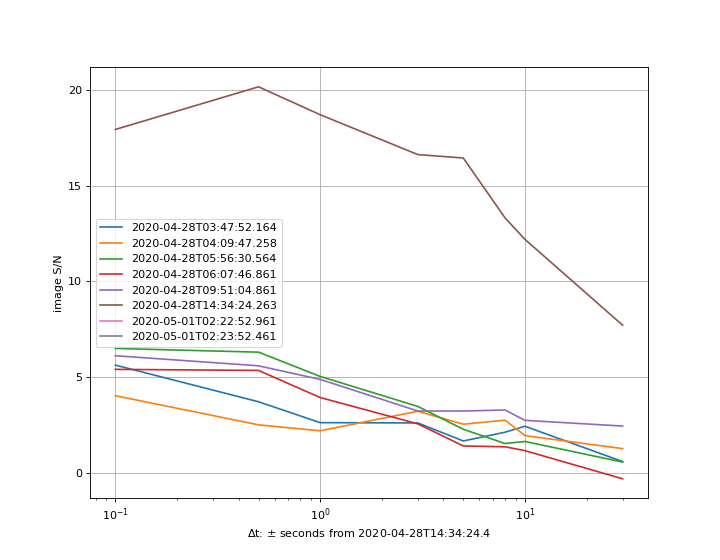

0.1 ['SGR 1935+2154'] [5.629776]
0.5 ['SGR 1935+2154'] [3.7182117]
1 ['SGR 1935+2154'] [2.6283221]
3 ['SGR 1935+2154'] [2.6125054]
5 ['SGR 1935+2154'] [1.6719856]
8 ['SGR 1935+2154'] [2.129828]
10 ['SGR 1935+2154'] [2.4396436]
30 ['SGR 1935+2154'] [0.59771353]
0.1 ['SGR 1935+2154'] [4.0335217]
0.5 ['SGR 1935+2154'] [2.5143385]
1 ['SGR 1935+2154'] [2.2032754]
3 ['SGR 1935+2154'] [3.2223177]
5 ['SGR 1935+2154'] [2.546918]
8 ['SGR 1935+2154'] [2.7578068]
10 ['SGR 1935+2154'] [1.9522648]
30 ['SGR 1935+2154'] [1.272452]
0.1 ['SGR 1935+2154'] [6.5002975]
0.5 ['SGR 1935+2154'] [6.3072414]
1 ['SGR 1935+2154'] [5.0410767]
3 ['SGR 1935+2154'] [3.4745505]
5 ['SGR 1935+2154'] [2.2821083]
8 ['SGR 1935+2154'] [1.5387497]
10 ['SGR 1935+2154'] [1.6455008]
30 ['SGR 1935+2154'] [0.5708029]
0.1 ['SGR 1935+2154'] [5.4086113]
0.5 ['SGR 1935+2154'] [5.353695]
1 ['SGR 1935+2154'] [3.9391627]
3 ['SGR 1935+2154'] [2.56295]
5 ['SGR 1935+2154'] [1.4126585]
8 ['SGR 1935+2154'] [1.3676342]
10 ['SGR 1935+2154'] [1.

In [256]:

plt.figure(figsize=(9,7))

plt.grid()


for burst in bursts:
    rs = burst['image_results']
    
    image_snr_by_dt_scale = {}
    
    
    for dt, r in rs.items():
        skyres = fits.open(r.skyres)[2]
        d=skyres.data
        #m = d['DETSIG']>0
        m = d['NAME'] == 'SGR 1935+2154'
        print(dt, d['NAME'][m], d['DETSIG'][m])

        if sum(m) != 0:
            image_snr_by_dt_scale[dt] = d['DETSIG'][m][0]
    
    plt.plot(
        np.array(list(image_snr_by_dt_scale.keys())),
        np.array(list(image_snr_by_dt_scale.values())),
        label=burst['utc']
    )
    
    if len(image_snr_by_dt_scale)==0:
        print("does not qualify")
        burst['image_confirmed'] = False
    else:
        burst['image_confirmed'] = True
        burst['image_snr_by_dt_scale']  = image_snr_by_dt_scale
        burst['best_image_time_scale'] = max(image_snr_by_dt_scale.items(), key=lambda x:x[1])


plt.xlabel("$\Delta$t: $\pm$ seconds from {}".format(burst_0_utc))
plt.ylabel("image S/N")
plt.legend()

plt.semilogx()

#!mkdir -pv draft/PAPER_SGR1935_INTEGRAL/fig/diagnostic
plt.savefig("draft/PAPER_SGR1935_INTEGRAL/fig/diagnostic/SN_vs_timescale_multiburst.pdf")


In [166]:
from collections import defaultdict
import glob
from astropy.wcs import WCS


<IPython.core.display.Javascript object>


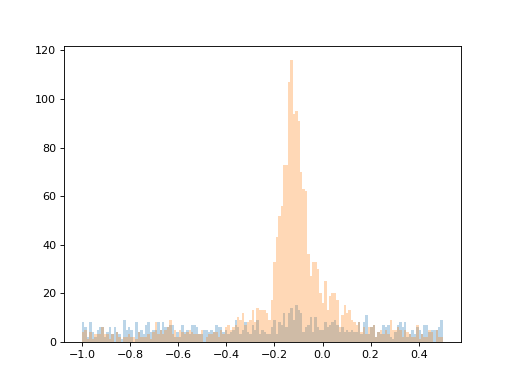

In [292]:
f=fits.open("/mnt/sshfs/isdc-in01//unsaved_data/savchenk/data/reduced/ddcache//byscw/2222/222200240010.000/evts_extract.v0/81903a67//source_evts.fits.gz")
evts = f[2].data

t_rel_s = (evts['TIME'] - burst_0_ijd)*24*3600
pif = evts['PIF_1']

plt.figure()

pif_thr = 0.3

h=plt.hist(
    t_rel_s[pif<=pif_thr], 
    np.linspace(-1,0.5, int(1.5*100)),
    alpha=0.3
)


h=plt.hist(
    t_rel_s[pif>pif_thr], 
    bins=h[1],
    alpha=0.3
)





2020-05-03T23:25:13.262
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-03T23:25:13.262/ANY


<IPython.core.display.Javascript object>


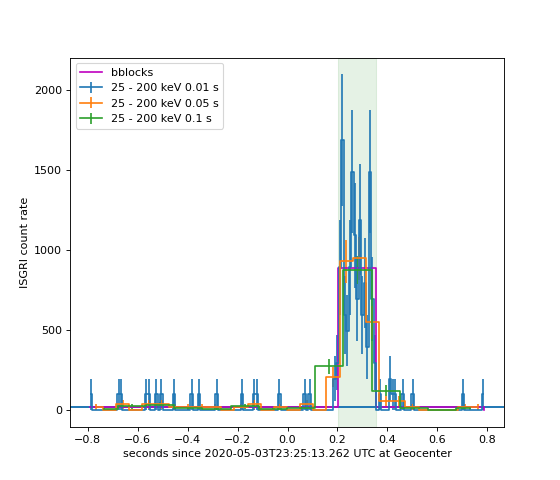

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 165
bins: [-0.79240111 -0.78233302 -0.77226492 -0.76219683 -0.75212874 -0.74206065
 -0.73199256 -0.72192447 -0.71185638 -0.70178828 -0.69172019 -0.6816521
 -0.67158401 -0.66151592 -0.65144783 -0.64137974 -0.63131165 -0.62124355
 -0.61117546 -0.60110737 -0.59103928 -0.58097119 -0.5709031  -0.56083501
 -0.55076691 -0.54069882 -0.53063073 -0.52056264 -0.51049455 -0.50042646
 -0.49035837 -0.48029028 -0.47022218 -0.46015409 -0.450086   -0.44001791
 -0.42994982 -0.41988173 -0.40981364 -0.39974554 -0.38967745 -0.37960936
 -0.36954127 -0.35947318 -0.34940509 -0.339337   -0.32926891 -0.31920081
 -0.30913272 -0.29906463 -0.28899654 -0.27892845 -0.26886036 -0.25879227
 -0.24872417 -0.23865608 -0.22858799 -0.2185199  -0.20845181 -0.19838372
 -0.18831563 -0.17824754 -0.16817944 -0.15811135 -0.14804326 -0.13797517
 -0.12790708 -0.11783899 -0.1077709  -0.0977028  -0.08763471 -0.07756662
 -0.06749853 -0.05743044 -0.04736235 -0.03729426 -0.02722617 -0.01715807
 -0.00708998  0.002978

{'t1_rel_s': 0.20289915846660733,
 't2_rel_s': 0.3543292928952724,
 'length_s': 0.15143013442866504,
 'bblock_success': True,
 'nevents_25_200': 136,
 'nevents_mgr50_25_200': 140,
 'bkg_pre_cts': 20.094438537856814,
 'bkg_post_cts': 23.043601675301378,
 'bkg_av_cts': 21.569020106579096,
 'nevents_bkg': 3.2661996142338516}

In [413]:
import re



def plot_one(t_refplot_utc):
    print(t_refplot_utc)
    sc = ic.get_sc(t_refplot_utc, ra=source_coord.ra.deg, dec=source_coord.dec.deg)
    dt_intgeo = sc['barytime']
    sc

    tc = ic.converttime("UTC", t_refplot_utc, "ANY")
    scwid = tc['SCWID']

    t_refplot_ijd = float(tc['IJD'])

    i_evts=fits.open("/mnt/sshfs/isdc-in01//unsaved_data/neronov/data/reduced/ddcache-private-staging-1.2//byscw/{}/{}.000/evts_extract.v0//06aef025/source_evts.fits.gz".format(scwid[:4], scwid))[2].data
    i_evts_en=i_evts

    ebands = [(25,200)]

    plt.figure(figsize=(7,6))

    rates={}

    bins = 0.05

    #tbin = 0.01
    
    burst_data={}

    for e1,e2 in ebands:
        m = i_evts_en['ENERGY']>=e1
        m &= i_evts_en['ENERGY']<e2

        t_plot_s = (i_evts['TIME'] + dt_intgeo/24/3600 -t_refplot_ijd)*24*3600

        m &= np.abs(t_plot_s)<0.8

        m &= i_evts['PIF_1']>0.3

        print("events in selection", sum(m))

        
        for tbin in 0.01, 0.05, 0.1:
            _ts = t_plot_s[m]
            bins=np.linspace(_ts.min(), _ts.max(), int((_ts.max()-_ts.min())/tbin))

            print("bins:", bins)

            h = np.histogram(t_plot_s[m], bins=bins)

            tc = (h[1][1:] + h[1][:-1])*0.5
            dt = (h[1][1:] - h[1][:-1])
            rate = h[0]/dt
            rate_err = h[0]**0.5/dt

            rates[(e1,e2)] = dict(
                rate = rate,
                rate_err = rate_err,
                tc = tc,
                dt = dt,
            )

            if True:
                plt.errorbar(
                    tc,
                    rate,
                    rate_err,
                    ds="steps-mid",
                    label="%.5lg - %.5lg keV %.5lg s"%(e1,e2,tbin),
                )
            else:
                plt.step(
                    tc,
                    rate,
                    ds="steps-mid",
                    label="%.5lg - %.5lg keV"%(e1,e2),
                    alpha=0.5,
                )


        #edges = bayesian_blocks(t_plot_s[m])
    
        x = t_plot_s[m]
        
        import BayesBlocks

        bb = BayesBlocks.bblock(pd.DataFrame(dict(TIME=x)))
        bb.find_blocks(0.1)

        h_blocks = np.histogram(x,bins=x[bb.change_points])
        
        burst_data['t1_rel_s'] = h_blocks[1][1]
        burst_data['t2_rel_s'] = h_blocks[1][-2]
        burst_data['length_s'] = burst_data['t2_rel_s']-burst_data['t1_rel_s']
        
        burst_data['bblock_success'] = (burst_data['t2_rel_s']-burst_data['t1_rel_s'])<1.
        
        if not burst_data['bblock_success'] :
            plt.title("fail!")
        
        burst_data['nevents_%.5lg_%.5lg'%(e1,e2)] = sum( (x>=burst_data['t1_rel_s']) & (x<=burst_data['t2_rel_s']) ) 
        burst_data['nevents_mgr50_%.5lg_%.5lg'%(e1,e2)] = sum( (x>=burst_data['t1_rel_s']-0.05) & (x<=burst_data['t2_rel_s']+0.05) ) 
        
        burst_data['bkg_pre_cts'] = h_blocks[0][0]/(h_blocks[1][1]-h_blocks[1][0])
        burst_data['bkg_post_cts'] = h_blocks[0][-1]/(h_blocks[1][-1]-h_blocks[1][-2])
        burst_data['bkg_av_cts'] = (burst_data['bkg_post_cts'] + burst_data['bkg_pre_cts'])/2.
        burst_data['nevents_bkg'] = burst_data['bkg_av_cts'] * burst_data['length_s']
        
        plt.axvspan(burst_data['t1_rel_s'], burst_data['t2_rel_s'], alpha=0.1, color="g")
        
        plt.axhline(burst_data['bkg_post_cts'])
        plt.axhline(burst_data['bkg_pre_cts'])
        
        plt.step( h_blocks[1],
                  np.concatenate([h_blocks[0]/(h_blocks[1][1:] - h_blocks[1][:-1]), [0]]),
                  color='m',
                  where='post',
                  label="bblocks"
                )
        
        
        #import BayesBlocks
        #BayesBlocks.find_blocks(pd.DataFrame())
    



    #plt.axvspan(
    #    (t_radio_p1_ijd - t_refplot_ijd)*24*3600 - radiotopo_s,
    #    (t_radio_p2_ijd - t_refplot_ijd)*24*3600 + radiotopo_s,
    #    alpha=0.2,
    #)

    #plt.axvline(
    #    (t_radio_detinf_ijd - t_refplot_ijd)*24*3600,
    #    alpha=0.5,
    #    label="radio ref",
    #    lw=2,
    #)


    #plt.axvline(
    #    (t_radio_p1_ijd - t_refplot_ijd)*24*3600,
    #    alpha=0.2,
    #    label="radio 1",
    #)


    #print("dt:")



    #plt.xlim([-0, 0.6])
    #plt.xlim([.40, 0.55])
    plt.ylabel("ISGRI count rate")
    plt.xlabel("seconds since "+t_refplot_utc+" UTC at Geocenter")

    plt.legend()

    fn = "draft/PAPER_SGR1935_INTEGRAL/data/burst-search/burst-plots/lc_peakandspec_{}.pdf".format(re.sub("[:]", "-", t_refplot_utc))
    plt.savefig(fn)
    plt.savefig(fn.replace(".pdf", ".png"))
    
    

    plt.show()
    
    return burst_data
    
    
    
plot_one("2020-05-03T23:25:13.262")




2020-04-28T03:47:52.164
2020-04-28T03:47:52.164
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T03:47:52.164/ANY


<IPython.core.display.Javascript object>


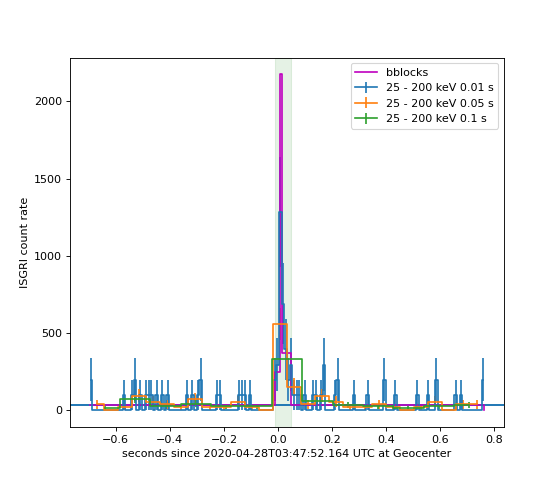

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 84
bins: [-0.69640579 -0.68627268 -0.67613957 -0.66600647 -0.65587336 -0.64574025
 -0.63560714 -0.62547404 -0.61534093 -0.60520782 -0.59507471 -0.58494161
 -0.5748085  -0.56467539 -0.55454228 -0.54440918 -0.53427607 -0.52414296
 -0.51400985 -0.50387674 -0.49374364 -0.48361053 -0.47347742 -0.46334431
 -0.45321121 -0.4430781  -0.43294499 -0.42281188 -0.41267878 -0.40254567
 -0.39241256 -0.38227945 -0.37214635 -0.36201324 -0.35188013 -0.34174702
 -0.33161392 -0.32148081 -0.3113477  -0.30121459 -0.29108149 -0.28094838
 -0.27081527 -0.26068216 -0.25054906 -0.24041595 -0.23028284 -0.22014973
 -0.21001663 -0.19988352 -0.18975041 -0.1796173  -0.1694842  -0.15935109
 -0.14921798 -0.13908487 -0.12895176 -0.11881866 -0.10868555 -0.09855244
 -0.08841933 -0.07828623 -0.06815312 -0.05802001 -0.0478869  -0.0377538
 -0.02762069 -0.01748758 -0.00735447  0.00277863  0.01291174  0.02304485
  0.03317796  0.04331106  0.05344417  0.06357728  0.07371039  0.08384349
  0.0939766   0.1041097

<IPython.core.display.Javascript object>


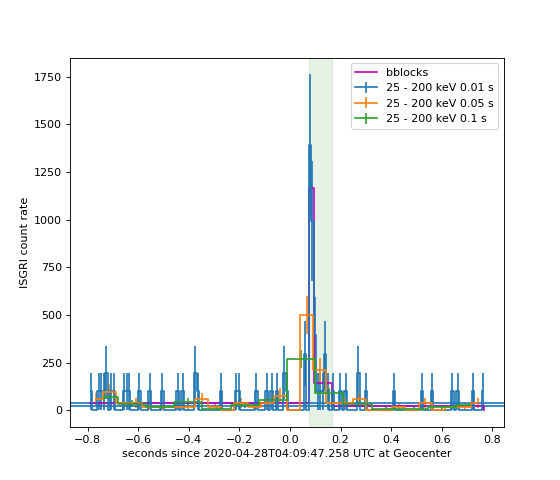

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 80
bins: [-0.79239278 -0.78231961 -0.77224645 -0.76217329 -0.75210012 -0.74202696
 -0.7319538  -0.72188063 -0.71180747 -0.70173431 -0.69166114 -0.68158798
 -0.67151482 -0.66144165 -0.65136849 -0.64129533 -0.63122216 -0.621149
 -0.61107584 -0.60100267 -0.59092951 -0.58085635 -0.57078318 -0.56071002
 -0.55063686 -0.54056369 -0.53049053 -0.52041737 -0.5103442  -0.50027104
 -0.49019788 -0.48012471 -0.47005155 -0.45997839 -0.44990522 -0.43983206
 -0.4297589  -0.41968573 -0.40961257 -0.39953941 -0.38946624 -0.37939308
 -0.36931992 -0.35924675 -0.34917359 -0.33910043 -0.32902726 -0.3189541
 -0.30888093 -0.29880777 -0.28873461 -0.27866144 -0.26858828 -0.25851512
 -0.24844195 -0.23836879 -0.22829563 -0.21822246 -0.2081493  -0.19807614
 -0.18800297 -0.17792981 -0.16785665 -0.15778348 -0.14771032 -0.13763716
 -0.12756399 -0.11749083 -0.10741767 -0.0973445  -0.08727134 -0.07719818
 -0.06712501 -0.05705185 -0.04697869 -0.03690552 -0.02683236 -0.0167592
 -0.00668603  0.00338713  

<IPython.core.display.Javascript object>


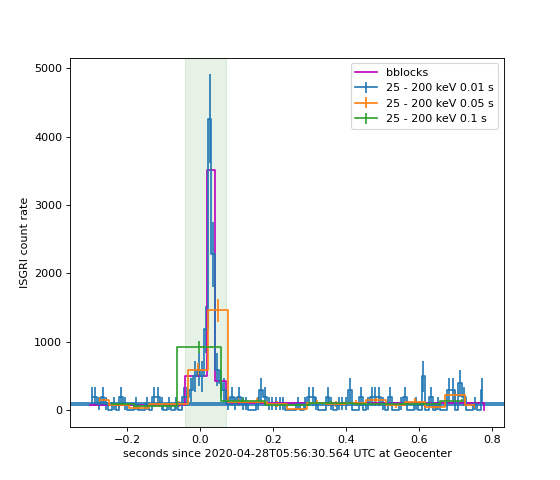

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 210
bins: [-0.30200374 -0.2919067  -0.28180965 -0.27171261 -0.26161556 -0.25151852
 -0.24142147 -0.23132443 -0.22122738 -0.21113034 -0.20103329 -0.19093625
 -0.1808392  -0.17074216 -0.16064511 -0.15054806 -0.14045102 -0.13035397
 -0.12025693 -0.11015988 -0.10006284 -0.08996579 -0.07986875 -0.0697717
 -0.05967466 -0.04957761 -0.03948057 -0.02938352 -0.01928648 -0.00918943
  0.00090761  0.01100466  0.0211017   0.03119875  0.04129579  0.05139284
  0.06148988  0.07158693  0.08168397  0.09178102  0.10187807  0.11197511
  0.12207216  0.1321692   0.14226625  0.15236329  0.16246034  0.17255738
  0.18265443  0.19275147  0.20284852  0.21294556  0.22304261  0.23313965
  0.2432367   0.25333374  0.26343079  0.27352783  0.28362488  0.29372192
  0.30381897  0.31391601  0.32401306  0.33411011  0.34420715  0.3543042
  0.36440124  0.37449829  0.38459533  0.39469238  0.40478942  0.41488647
  0.42498351  0.43508056  0.4451776   0.45527465  0.46537169  0.47546874
  0.48556578  0.4956628

<IPython.core.display.Javascript object>


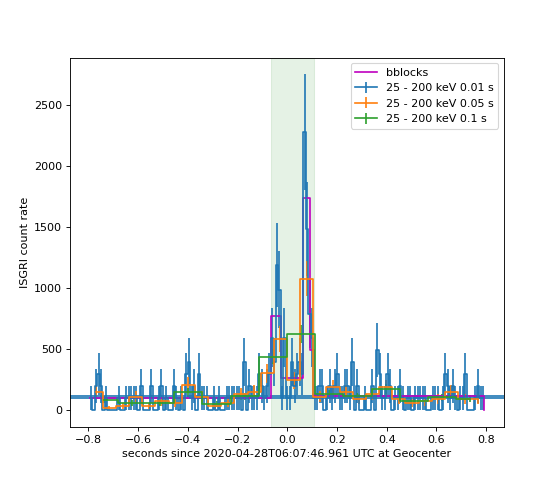

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 261
bins: [-0.79448514 -0.78437934 -0.77427355 -0.76416776 -0.75406196 -0.74395617
 -0.73385038 -0.72374459 -0.71363879 -0.703533   -0.69342721 -0.68332141
 -0.67321562 -0.66310983 -0.65300404 -0.64289824 -0.63279245 -0.62268666
 -0.61258086 -0.60247507 -0.59236928 -0.58226349 -0.57215769 -0.5620519
 -0.55194611 -0.54184031 -0.53173452 -0.52162873 -0.51152294 -0.50141714
 -0.49131135 -0.48120556 -0.47109976 -0.46099397 -0.45088818 -0.44078238
 -0.43067659 -0.4205708  -0.41046501 -0.40035921 -0.39025342 -0.38014763
 -0.37004183 -0.35993604 -0.34983025 -0.33972446 -0.32961866 -0.31951287
 -0.30940708 -0.29930128 -0.28919549 -0.2790897  -0.26898391 -0.25887811
 -0.24877232 -0.23866653 -0.22856073 -0.21845494 -0.20834915 -0.19824336
 -0.18813756 -0.17803177 -0.16792598 -0.15782018 -0.14771439 -0.1376086
 -0.12750281 -0.11739701 -0.10729122 -0.09718543 -0.08707963 -0.07697384
 -0.06686805 -0.05676226 -0.04665646 -0.03655067 -0.02644488 -0.01633908
 -0.00623329  0.0038725

<IPython.core.display.Javascript object>


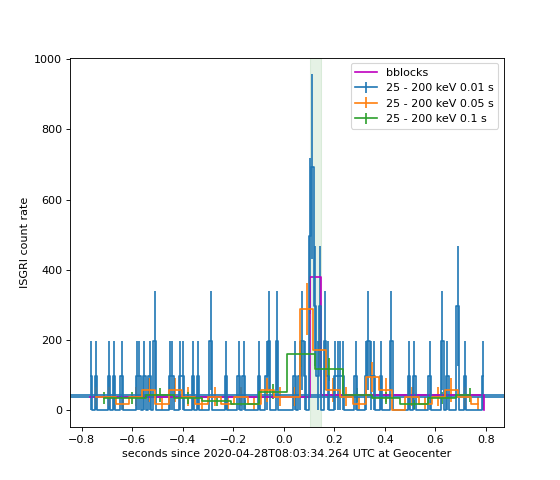

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 79
bins: [-0.76854647 -0.75846188 -0.74837728 -0.73829269 -0.72820809 -0.7181235
 -0.7080389  -0.69795431 -0.68786971 -0.67778512 -0.66770052 -0.65761593
 -0.64753133 -0.63744674 -0.62736214 -0.61727755 -0.60719295 -0.59710836
 -0.58702376 -0.57693917 -0.56685457 -0.55676998 -0.54668538 -0.53660079
 -0.52651619 -0.5164316  -0.506347   -0.49626241 -0.48617781 -0.47609322
 -0.46600862 -0.45592403 -0.44583943 -0.43575484 -0.42567024 -0.41558565
 -0.40550105 -0.39541646 -0.38533186 -0.37524727 -0.36516267 -0.35507808
 -0.34499348 -0.33490889 -0.32482429 -0.3147397  -0.3046551  -0.29457051
 -0.28448591 -0.27440132 -0.26431672 -0.25423212 -0.24414753 -0.23406293
 -0.22397834 -0.21389374 -0.20380915 -0.19372455 -0.18363996 -0.17355536
 -0.16347077 -0.15338617 -0.14330158 -0.13321698 -0.12313239 -0.11304779
 -0.1029632  -0.0928786  -0.08279401 -0.07270941 -0.06262482 -0.05254022
 -0.04245563 -0.03237103 -0.02228644 -0.01220184 -0.00211725  0.00796735
  0.01805194  0.0281365

<IPython.core.display.Javascript object>


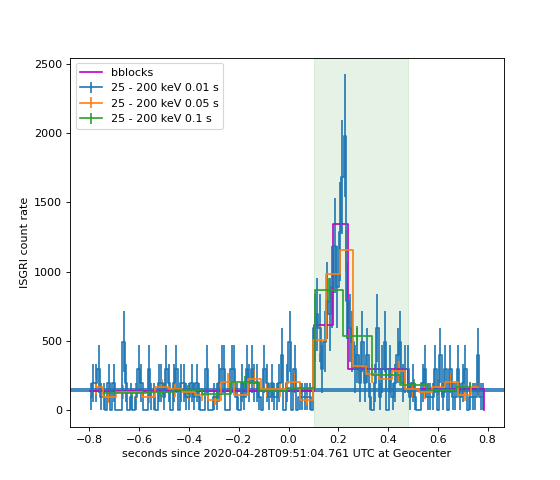

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 375
bins: [-0.79885491 -0.78875612 -0.77865732 -0.76855853 -0.75845973 -0.74836094
 -0.73826214 -0.72816335 -0.71806456 -0.70796576 -0.69786697 -0.68776817
 -0.67766938 -0.66757059 -0.65747179 -0.647373   -0.6372742  -0.62717541
 -0.61707661 -0.60697782 -0.59687903 -0.58678023 -0.57668144 -0.56658264
 -0.55648385 -0.54638505 -0.53628626 -0.52618747 -0.51608867 -0.50598988
 -0.49589108 -0.48579229 -0.47569349 -0.4655947  -0.45549591 -0.44539711
 -0.43529832 -0.42519952 -0.41510073 -0.40500194 -0.39490314 -0.38480435
 -0.37470555 -0.36460676 -0.35450796 -0.34440917 -0.33431038 -0.32421158
 -0.31411279 -0.30401399 -0.2939152  -0.2838164  -0.27371761 -0.26361882
 -0.25352002 -0.24342123 -0.23332243 -0.22322364 -0.21312484 -0.20302605
 -0.19292726 -0.18282846 -0.17272967 -0.16263087 -0.15253208 -0.14243329
 -0.13233449 -0.1222357  -0.1121369  -0.10203811 -0.09193931 -0.08184052
 -0.07174173 -0.06164293 -0.05154414 -0.04144534 -0.03134655 -0.02124775
 -0.01114896 -0.00105

<IPython.core.display.Javascript object>


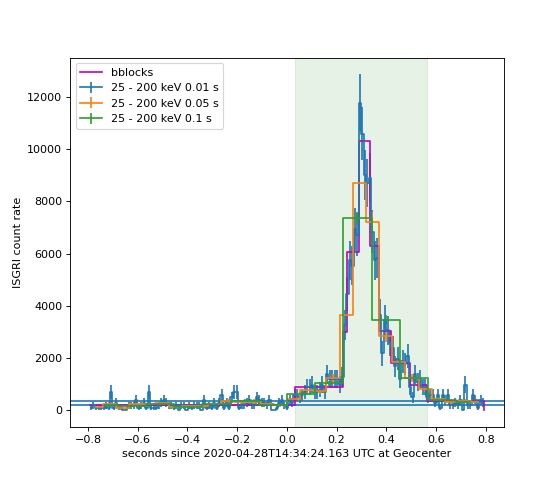

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 1814
bins: [-0.79284634 -0.78273821 -0.77263008 -0.76252194 -0.75241381 -0.74230567
 -0.73219754 -0.72208941 -0.71198127 -0.70187314 -0.691765   -0.68165687
 -0.67154874 -0.6614406  -0.65133247 -0.64122434 -0.6311162  -0.62100807
 -0.61089993 -0.6007918  -0.59068367 -0.58057553 -0.5704674  -0.56035927
 -0.55025113 -0.540143   -0.53003486 -0.51992673 -0.5098186  -0.49971046
 -0.48960233 -0.4794942  -0.46938606 -0.45927793 -0.44916979 -0.43906166
 -0.42895353 -0.41884539 -0.40873726 -0.39862913 -0.38852099 -0.37841286
 -0.36830472 -0.35819659 -0.34808846 -0.33798032 -0.32787219 -0.31776406
 -0.30765592 -0.29754779 -0.28743965 -0.27733152 -0.26722339 -0.25711525
 -0.24700712 -0.23689899 -0.22679085 -0.21668272 -0.20657458 -0.19646645
 -0.18635832 -0.17625018 -0.16614205 -0.15603391 -0.14592578 -0.13581765
 -0.12570951 -0.11560138 -0.10549325 -0.09538511 -0.08527698 -0.07516884
 -0.06506071 -0.05495258 -0.04484444 -0.03473631 -0.02462818 -0.01452004
 -0.00441191  0.0056

<IPython.core.display.Javascript object>


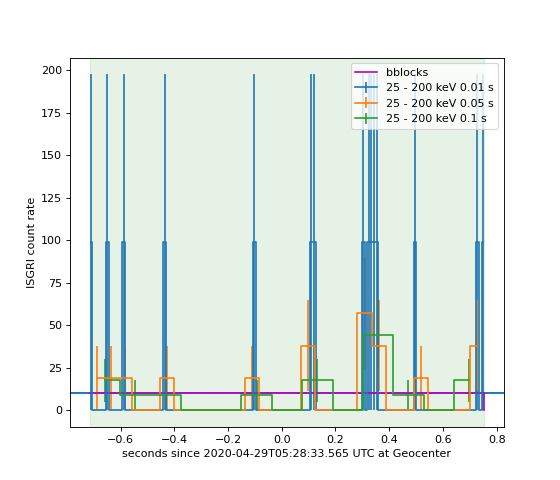

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 15
bins: [-0.71465136 -0.7045233  -0.69439524 -0.68426718 -0.67413911 -0.66401105
 -0.65388299 -0.64375493 -0.63362687 -0.62349881 -0.61337075 -0.60324269
 -0.59311463 -0.58298657 -0.5728585  -0.56273044 -0.55260238 -0.54247432
 -0.53234626 -0.5222182  -0.51209014 -0.50196208 -0.49183402 -0.48170596
 -0.47157789 -0.46144983 -0.45132177 -0.44119371 -0.43106565 -0.42093759
 -0.41080953 -0.40068147 -0.39055341 -0.38042535 -0.37029729 -0.36016922
 -0.35004116 -0.3399131  -0.32978504 -0.31965698 -0.30952892 -0.29940086
 -0.2892728  -0.27914474 -0.26901668 -0.25888861 -0.24876055 -0.23863249
 -0.22850443 -0.21837637 -0.20824831 -0.19812025 -0.18799219 -0.17786413
 -0.16773607 -0.157608   -0.14747994 -0.13735188 -0.12722382 -0.11709576
 -0.1069677  -0.09683964 -0.08671158 -0.07658352 -0.06645546 -0.05632739
 -0.04619933 -0.03607127 -0.02594321 -0.01581515 -0.00568709  0.00444097
  0.01456903  0.02469709  0.03482515  0.04495322  0.05508128  0.06520934
  0.0753374   0.085465

<IPython.core.display.Javascript object>


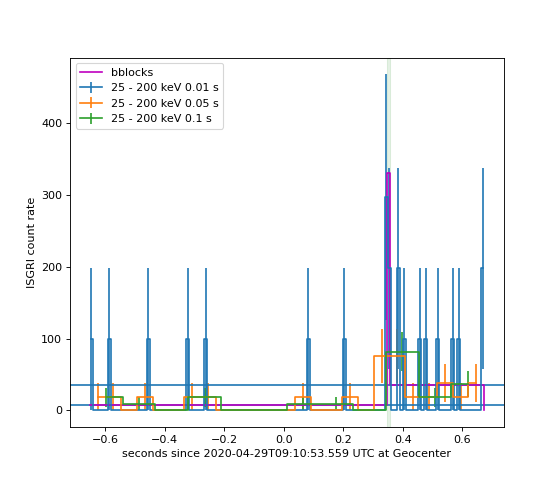

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 22
bins: [-0.65205473 -0.64193128 -0.63180783 -0.62168438 -0.61156093 -0.60143748
 -0.59131403 -0.58119058 -0.57106713 -0.56094368 -0.55082023 -0.54069678
 -0.53057333 -0.52044988 -0.51032643 -0.50020298 -0.49007953 -0.47995608
 -0.46983263 -0.45970918 -0.44958574 -0.43946229 -0.42933884 -0.41921539
 -0.40909194 -0.39896849 -0.38884504 -0.37872159 -0.36859814 -0.35847469
 -0.34835124 -0.33822779 -0.32810434 -0.31798089 -0.30785744 -0.29773399
 -0.28761054 -0.27748709 -0.26736364 -0.25724019 -0.24711674 -0.23699329
 -0.22686984 -0.21674639 -0.20662294 -0.19649949 -0.18637604 -0.17625259
 -0.16612914 -0.15600569 -0.14588224 -0.13575879 -0.12563534 -0.11551189
 -0.10538845 -0.095265   -0.08514155 -0.0750181  -0.06489465 -0.0547712
 -0.04464775 -0.0345243  -0.02440085 -0.0142774  -0.00415395  0.0059695
  0.01609295  0.0262164   0.03633985  0.0464633   0.05658675  0.0667102
  0.07683365  0.0869571   0.09708055  0.107204    0.11732745  0.1274509
  0.13757435  0.1476978   

<IPython.core.display.Javascript object>


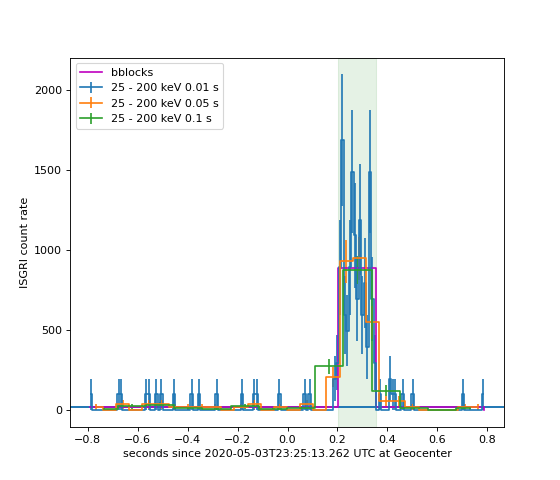

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 165
bins: [-0.79240111 -0.78233302 -0.77226492 -0.76219683 -0.75212874 -0.74206065
 -0.73199256 -0.72192447 -0.71185638 -0.70178828 -0.69172019 -0.6816521
 -0.67158401 -0.66151592 -0.65144783 -0.64137974 -0.63131165 -0.62124355
 -0.61117546 -0.60110737 -0.59103928 -0.58097119 -0.5709031  -0.56083501
 -0.55076691 -0.54069882 -0.53063073 -0.52056264 -0.51049455 -0.50042646
 -0.49035837 -0.48029028 -0.47022218 -0.46015409 -0.450086   -0.44001791
 -0.42994982 -0.41988173 -0.40981364 -0.39974554 -0.38967745 -0.37960936
 -0.36954127 -0.35947318 -0.34940509 -0.339337   -0.32926891 -0.31920081
 -0.30913272 -0.29906463 -0.28899654 -0.27892845 -0.26886036 -0.25879227
 -0.24872417 -0.23865608 -0.22858799 -0.2185199  -0.20845181 -0.19838372
 -0.18831563 -0.17824754 -0.16817944 -0.15811135 -0.14804326 -0.13797517
 -0.12790708 -0.11783899 -0.1077709  -0.0977028  -0.08763471 -0.07756662
 -0.06749853 -0.05743044 -0.04736235 -0.03729426 -0.02722617 -0.01715807
 -0.00708998  0.002978

<IPython.core.display.Javascript object>


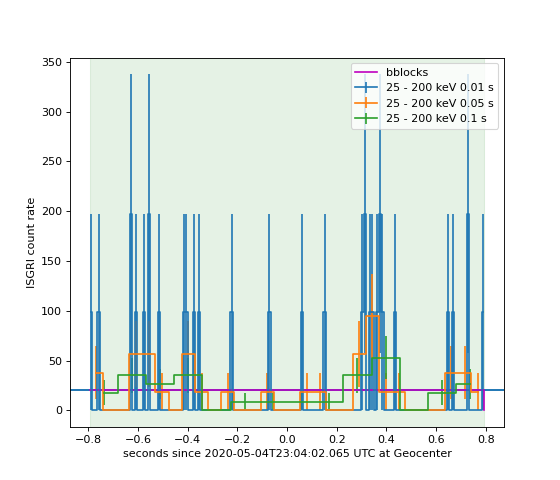

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 32
bins: [-0.79484606 -0.78472665 -0.77460724 -0.76448783 -0.75436842 -0.74424902
 -0.73412961 -0.7240102  -0.71389079 -0.70377139 -0.69365198 -0.68353257
 -0.67341316 -0.66329375 -0.65317435 -0.64305494 -0.63293553 -0.62281612
 -0.61269671 -0.60257731 -0.5924579  -0.58233849 -0.57221908 -0.56209968
 -0.55198027 -0.54186086 -0.53174145 -0.52162204 -0.51150264 -0.50138323
 -0.49126382 -0.48114441 -0.47102501 -0.4609056  -0.45078619 -0.44066678
 -0.43054737 -0.42042797 -0.41030856 -0.40018915 -0.39006974 -0.37995034
 -0.36983093 -0.35971152 -0.34959211 -0.3394727  -0.3293533  -0.31923389
 -0.30911448 -0.29899507 -0.28887567 -0.27875626 -0.26863685 -0.25851744
 -0.24839803 -0.23827863 -0.22815922 -0.21803981 -0.2079204  -0.19780099
 -0.18768159 -0.17756218 -0.16744277 -0.15732336 -0.14720396 -0.13708455
 -0.12696514 -0.11684573 -0.10672632 -0.09660692 -0.08648751 -0.0763681
 -0.06624869 -0.05612929 -0.04600988 -0.03589047 -0.02577106 -0.01565165
 -0.00553225  0.0045871

<IPython.core.display.Javascript object>


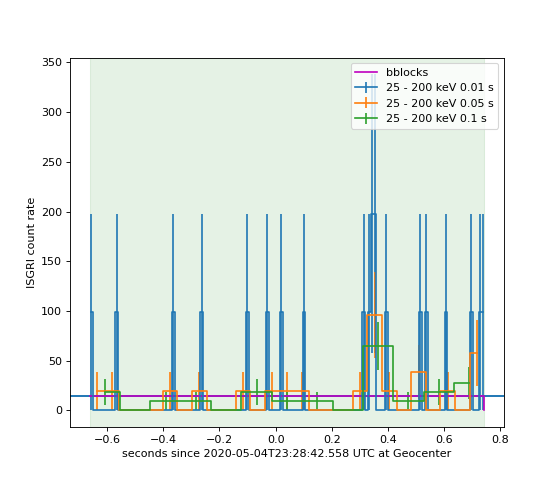

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 21
bins: [-0.6615756  -0.65147319 -0.64137077 -0.63126835 -0.62116594 -0.61106352
 -0.60096111 -0.59085869 -0.58075627 -0.57065386 -0.56055144 -0.55044903
 -0.54034661 -0.53024419 -0.52014178 -0.51003936 -0.49993695 -0.48983453
 -0.47973211 -0.4696297  -0.45952728 -0.44942487 -0.43932245 -0.42922003
 -0.41911762 -0.4090152  -0.39891279 -0.38881037 -0.37870795 -0.36860554
 -0.35850312 -0.34840071 -0.33829829 -0.32819587 -0.31809346 -0.30799104
 -0.29788863 -0.28778621 -0.27768379 -0.26758138 -0.25747896 -0.24737655
 -0.23727413 -0.22717171 -0.2170693  -0.20696688 -0.19686447 -0.18676205
 -0.17665963 -0.16655722 -0.1564548  -0.14635239 -0.13624997 -0.12614755
 -0.11604514 -0.10594272 -0.09584031 -0.08573789 -0.07563547 -0.06553306
 -0.05543064 -0.04532823 -0.03522581 -0.02512339 -0.01502098 -0.00491856
  0.00518385  0.01528627  0.02538869  0.0354911   0.04559352  0.05569593
  0.06579835  0.07590077  0.08600318  0.0961056   0.10620801  0.11631043
  0.12641285  0.136515

In [414]:
for burst in bursts[:]:
    print(burst['utc_integral'])
    
    burst['bblocks'] = plot_one(burst['utc_integral'])

In [425]:
_bursts=[]
for b in bursts:
    if abs(b['bblocks']['t2_rel_s']-b['bblocks']['t1_rel_s'])<1.:
        _bursts.append(b)
    else:
        print("skipping", b['utc_integral'])

skipping 2020-04-29T05:28:33.565
skipping 2020-05-04T23:04:02.065
skipping 2020-05-04T23:28:42.558


In [428]:
def simplify(x):
    if isinstance(x, np.ndarray):
        return simplify(list(x))
    
    #if isinstance(x, np.core.multiarray.scalar):
    #    return float(x)
    
    if isinstance(x, list):
        return [simplify(a) for a in x]
    
    if isinstance(x, tuple):
        return tuple([simplify(a) for a in x])


    if isinstance(x, dict):
        return {simplify(a):simplify(b) for a,b in x.items()}

    try:
        return float(x)
    except:
        return x

In [429]:
yaml.dump(simplify(_bursts), open("draft/PAPER_SGR1935_INTEGRAL/data/burst-search/bursts.yaml", "w"))